In [71]:
# standard library imports
from __future__ import absolute_import, division, print_function
import os
import sys
import argparse
import gc

# standard numerical library imports
import math
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from matplotlib import rc
import mplhep as hep

import tensorflow as tf
from tensorflow import keras

import keras.backend as K
from tensorflow.keras.layers import Lambda, Dense, Input, Layer, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.initializers import Constant
from tensorflow.keras.backend import concatenate

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, remap_pids, to_categorical



In [2]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.set_visible_devices(gpus[0], 'GPU')

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


2024-08-12 23:14:45.060066: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-12 23:14:45.065818: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-12 23:14:45.066052: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
sys.path.append('../')
import DCTR


In [4]:
from importlib import reload 
reload(DCTR)


<module 'DCTR' from '/tf/home/DCTR_Paper/DCTR_FP/20240806_B-Fragmentation_bootsrapping/../DCTR.py'>

In [5]:

num = int(1e6)

data_dir = '../../Data'
# NAF
# data_dir = '/nfs/dust/cms/user/puschman/pythia8307/examples/output'


In [6]:
X0 = []

for i in range(13, 16):
    dataset = np.load(f'{data_dir}/B-Fragmentation_Rb_1.056/bootstrapping_Xb_multC_multNeutra_listBtop_listBextra-Rb_1.056_1M_seed{i}_CP5.npz')
    print(dataset.files)
    X0.extend(dataset['a'])

X0 = np.array(X0)
print(X0.shape)



['a', 'b', 'c', 'd', 'e']
['a', 'b', 'c', 'd', 'e']
['a', 'b', 'c', 'd', 'e']
(5977788,)


In [7]:
X1 = []

for i in range(13, 16):
    dataset = np.load(f'{data_dir}/B-Fragmentation_Rb_0.855/bootstrapping_Xb_multC_multNeutra_listBtop_listBextra-Rb_0.855_1M_seed{i}_CP5.npz')
    print(dataset.files)
    X1.extend(dataset['a'])

X1 = np.array(X1)
print(X1.shape)


['a', 'b', 'c', 'd', 'e']
['a', 'b', 'c', 'd', 'e']
['a', 'b', 'c', 'd', 'e']
(5978106,)


In [8]:
print(X0.shape)
print(X1.shape)


(5977788,)
(5978106,)


In [9]:
X0_pari = []
X0_dispari = []
X1_pari = []
X1_dispari = []


for i, _ in enumerate(X0):
    if i % 2 == 0:
        X0_pari.append(X0[i])
    else:
        X0_dispari.append(X0[i])


for i, _ in enumerate(X1):
    if i % 2 == 0:
        X1_pari.append(X1[i])
    else:
        X1_dispari.append(X1[i])


In [10]:
print(len(X0_pari))
print(len(X1_pari))

2988894
2989053


In [11]:
print(len(X0_dispari))
print(len(X1_dispari))

2988894
2989053


In [12]:
X0_tot = []
for i, _ in enumerate(X0_pari):
    X0_tot.append([[X0_pari[i]], [X0_dispari[i]]])
    

In [13]:
X0_tot = np.array(X0_tot)
print(X0_tot.shape)


(2988894, 2, 1)


In [14]:
print(X0_tot)

[[[0.4727821 ]
  [0.77345092]]

 [[0.81807189]
  [0.68890812]]

 [[0.31941123]
  [0.89386035]]

 ...

 [[0.6885071 ]
  [0.68362032]]

 [[0.42146701]
  [0.77048908]]

 [[0.37598829]
  [0.36507024]]]


In [15]:
X1_tot = []
for i, _ in enumerate(X1_pari):
    X1_tot.append([[X1_pari[i]], [X1_dispari[i]]])
    

In [16]:
X1_tot = np.array(X1_tot)
print(X1_tot.shape)


(2989053, 2, 1)


In [17]:
print(X1_tot)

[[[0.4727821 ]
  [0.77345092]]

 [[0.81807189]
  [0.7358395 ]]

 [[0.32661311]
  [0.91397603]]

 ...

 [[0.86739354]
  [0.81468214]]

 [[0.81390241]
  [0.85790137]]

 [[0.92550745]
  [0.99964699]]]


In [18]:
# num random samples

rand0 = np.random.choice(len(X0_tot), num) # num_evts random indices
rand1 = np.random.choice(len(X1_tot), num)

X0_tot = X0_tot[rand0]
X1_tot = X1_tot[rand1]



In [20]:
print(X0_tot.shape)
print(X1_tot.shape)


(1000000, 2, 1)
(1000000, 2, 1)


In [22]:
model_dir = './saved_models'
model_list = []

for i in range(1, 51):
    model_list.append(f'{model_dir}/DCTR_pp_tt_1D_Rb_mine_xB_CP5_nominal_1M_iter_{i:02d}.h5')

print(*model_list, sep='\n')


./saved_models/DCTR_pp_tt_1D_Rb_mine_xB_CP5_nominal_1M_iter_01.h5
./saved_models/DCTR_pp_tt_1D_Rb_mine_xB_CP5_nominal_1M_iter_02.h5
./saved_models/DCTR_pp_tt_1D_Rb_mine_xB_CP5_nominal_1M_iter_03.h5
./saved_models/DCTR_pp_tt_1D_Rb_mine_xB_CP5_nominal_1M_iter_04.h5
./saved_models/DCTR_pp_tt_1D_Rb_mine_xB_CP5_nominal_1M_iter_05.h5
./saved_models/DCTR_pp_tt_1D_Rb_mine_xB_CP5_nominal_1M_iter_06.h5
./saved_models/DCTR_pp_tt_1D_Rb_mine_xB_CP5_nominal_1M_iter_07.h5
./saved_models/DCTR_pp_tt_1D_Rb_mine_xB_CP5_nominal_1M_iter_08.h5
./saved_models/DCTR_pp_tt_1D_Rb_mine_xB_CP5_nominal_1M_iter_09.h5
./saved_models/DCTR_pp_tt_1D_Rb_mine_xB_CP5_nominal_1M_iter_10.h5
./saved_models/DCTR_pp_tt_1D_Rb_mine_xB_CP5_nominal_1M_iter_11.h5
./saved_models/DCTR_pp_tt_1D_Rb_mine_xB_CP5_nominal_1M_iter_12.h5
./saved_models/DCTR_pp_tt_1D_Rb_mine_xB_CP5_nominal_1M_iter_13.h5
./saved_models/DCTR_pp_tt_1D_Rb_mine_xB_CP5_nominal_1M_iter_14.h5
./saved_models/DCTR_pp_tt_1D_Rb_mine_xB_CP5_nominal_1M_iter_15.h5
./saved_mo

In [38]:

Phi_sizes = (100,100,128)
F_sizes = (100,100,100)
input_dim=1

dctr = PFN(input_dim = input_dim,
           Phi_sizes = Phi_sizes, 
           F_sizes   = F_sizes,
           summary   = False)


wgts_list = []
for model in model_list:
    dctr.load_weights(model)
    preds_1 = dctr.predict(X1_tot, batch_size=1000)
    weights_1 = np.ones(len(X1_tot))
    np.divide(preds_1[:,0], preds_1[:,1], out = weights_1, where=preds_1[:,1]!=0.0)

    wgts_list.append(weights_1)

wgts_list = np.array(wgts_list)

np.save(f'{data_dir}/wgts_list_1M_50iter.npy', wgts_list)




2024-08-12 23:47:16.827229: I tensorflow/stream_executor/cuda/cuda_driver.cc:739] failed to allocate 512.00M (536870912 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-08-12 23:47:16.827418: I tensorflow/stream_executor/cuda/cuda_driver.cc:739] failed to allocate 460.80M (483183872 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-08-12 23:47:16.827594: I tensorflow/stream_executor/cuda/cuda_driver.cc:739] failed to allocate 414.72M (434865664 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-08-12 23:47:16.827787: I tensorflow/stream_executor/cuda/cuda_driver.cc:739] failed to allocate 373.25M (391379200 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-08-12 23:47:16.827989: I tensorflow/stream_executor/cuda/cuda_driver.cc:739] failed to allocate 335.92M (352241408 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-08-12 23:47:16.828197: I tensorflow/stream_executor/cuda/cuda_driver.cc:739] failed to allocate

In [40]:
wgts_list = np.load(f'{data_dir}/wgts_list_1M_50iter.npy')

print(wgts_list.shape)
print(wgts_list)


(50, 1000000)
[[0.9609946  0.71739143 0.76941228 ... 0.52912056 1.21212852 1.16068041]
 [0.95335305 0.71455508 0.77260101 ... 0.53065062 1.24070239 1.13782299]
 [0.94398791 0.722242   0.76411015 ... 0.51881588 1.22298789 1.14981115]
 ...
 [0.98014724 0.70278108 0.78135246 ... 0.52868879 1.24125814 1.10743618]
 [0.95824629 0.72700632 0.75677478 ... 0.54962969 1.23142827 1.1253196 ]
 [0.95154566 0.7190395  0.7740289  ... 0.54201823 1.19267797 1.12511909]]


In [41]:
wgts_mean_per_event = np.mean(wgts_list, axis = 0)
print(np.shape(wgts_mean_per_event))


(1000000,)


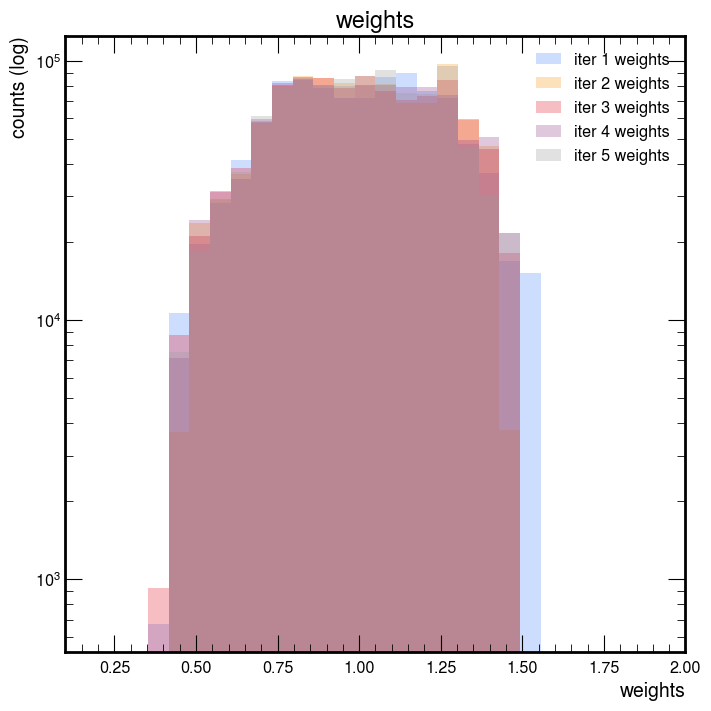

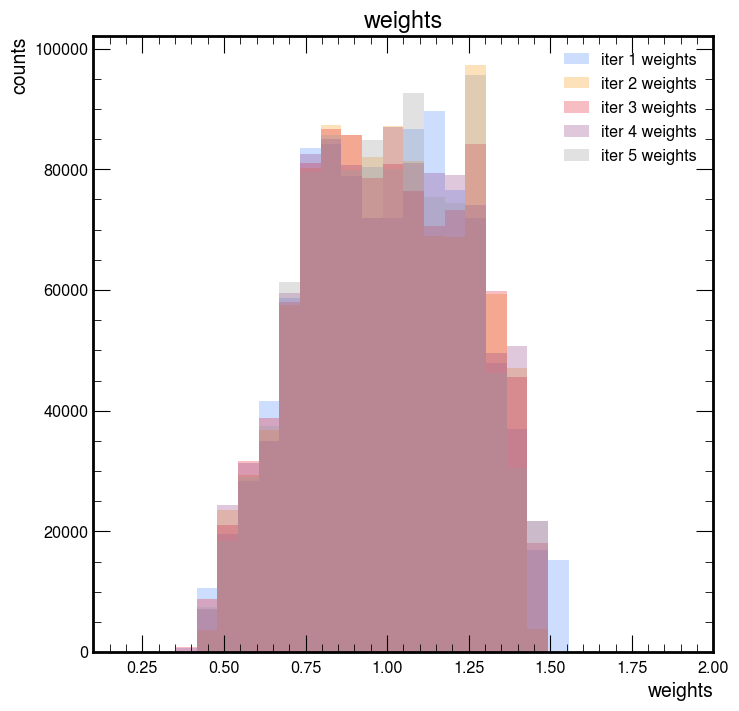

In [44]:
# plot and check dctr rwgt
font = {'size'   : 14}
rc('font', **font)

wgts_args = []
for i, _ in enumerate(wgts_list):
    if i >= 5:
        continue
    wgts_args.append([wgts_list[i], rf'iter {i + 1} weights'])
    
# wgts_args.append([wgts_mean_per_event, rf'mean weights']) # mean wgt per event

# y log scale
DCTR.plot_weights(wgts_args, start = 0.1, stop = 2, xscale='lin') # log x
# DCTR.plot_weights(wgts_args, start = 0, stop = 5, xscale='lin') # linear x

# y lin scale
DCTR.plot_weights(wgts_args, start = 0.1, stop = 2, xscale='lin', yscale='lin') # log x
# DCTR.plot_weights(wgts_args, start = 0, stop = 5, xscale='lin', yscale='lin') # linear x


In [45]:
# check weights

# when building ratio of square root of squared weights, the value we are comparing against has wgt = 1 for all events 
# -> /sqrt(num_events) is all we need

def get_wgts_stats(wgts_list):
    min_wgt_list    = []
    max_wgt_list    = []
    mean_wgt_list   = []
    ratio_wgts_list = []
    sqrt_num_events = math.sqrt(len(wgts_list[0]))
    for i, wgts in enumerate(wgts_list):
        min_wgt_list.append(np.min(wgts))
        max_wgt_list.append(np.max(wgts))
        mean_wgt_list.append(np.mean(wgts))
        
        sqrt_sum_wgts_squared = math.sqrt(np.sum(np.power(wgts, 2)))
        ratio_wgts_list.append(sqrt_num_events/sqrt_sum_wgts_squared)

    return np.array(min_wgt_list), np.array(max_wgt_list), np.array(mean_wgt_list), np.array(ratio_wgts_list)


In [48]:
min_wgt_list, max_wgt_list, mean_wgt_list, ratio_wgt_list = get_wgts_stats(wgts_list)
np.set_printoptions(precision=5, suppress=True)

print(f'{min_wgt_list   = }\n')
print(f'{max_wgt_list   = }\n')
print(f'{mean_wgt_list  = }\n')
print(f'{ratio_wgt_list = }\n')

mean_mean_wgt = np.mean(mean_wgt_list)
std_mean_wgt  = np.std(mean_wgt_list)

mean_ratio_wgt = np.mean(ratio_wgt_list)
std_ratio_wgt  = np.std(ratio_wgt_list)

print(f'mean weights:\n\
{mean_mean_wgt:.5f} +/- {std_mean_wgt:.5f}\n')

print(f'ratio of sqrt of sum of squared weights:\n\
{mean_ratio_wgt:.5f} +/- {std_ratio_wgt:.5f}')


min_wgt_list   = array([0.40494, 0.44609, 0.36743, 0.42622, 0.41792, 0.44714, 0.45555,
       0.40429, 0.40505, 0.43397, 0.42042, 0.43807, 0.41832, 0.45204,
       0.42802, 0.38753, 0.4449 , 0.39121, 0.43628, 0.40438, 0.41745,
       0.41573, 0.40842, 0.40012, 0.39743, 0.4305 , 0.37678, 0.41993,
       0.35647, 0.45065, 0.418  , 0.35723, 0.41347, 0.41925, 0.45449,
       0.43015, 0.37589, 0.43401, 0.42361, 0.41408, 0.37155, 0.39514,
       0.42886, 0.39904, 0.38966, 0.44302, 0.45919, 0.38865, 0.44637,
       0.45257])

max_wgt_list   = array([1.52482, 1.43578, 1.4848 , 1.46204, 1.48823, 1.48075, 1.48809,
       1.4852 , 1.49562, 1.49635, 1.52049, 1.44365, 1.55818, 1.45157,
       1.51267, 1.49574, 1.5308 , 1.50809, 1.52074, 1.49185, 1.48077,
       1.55419, 1.4644 , 1.51539, 1.46267, 1.52006, 1.57975, 1.47642,
       1.5014 , 1.54471, 1.46806, 1.46835, 1.44494, 1.53321, 1.47716,
       1.52304, 1.44817, 1.59693, 1.49371, 1.46033, 1.48588, 1.52989,
       1.50927, 1.51824, 1.51287, 1.48

In [ ]:
# covariance calculations

In [49]:
# covariance matrix using weighted samples
def weighted_cov(data, weights):
    # print(f'{np.shape(data) = }')

    # Calculate weighted mean
    weighted_mean = np.average(data, axis=0, weights=weights)
    # print(f'{np.shape(weighted_mean) = }')
    # print(f'{weighted_mean = }')

    # Calculate centered data
    centered_data = data - weighted_mean
    # print(f'{np.shape(centered_data) = }')

    # Calculate weighted covariance matrix
    vars = len(data[0,:]) # num of variables per sample
    weighted_covariance = np.zeros(shape=(vars, vars))
    for i in range(vars):
        for j in range(vars):
            weighted_covariance[i, j] = np.sum(
                weights * centered_data[:,i] * centered_data[:,j]) / np.sum(weights)

    return weighted_covariance
    

# correlation matrix using weighted samples
def weighted_corr(data, weights):
    cov = weighted_cov(data, weights)

    # Calculate diagonal matrix for standard deviations
    std_dev = np.sqrt(np.diag(cov))
    std_dev_matrix = np.outer(std_dev, std_dev)

    # Calculate correlation matrix
    weighted_correlation = cov / std_dev_matrix

    return weighted_correlation
    


In [50]:
import matplotlib.patheffects as pe

def plot_matrix(matrix, title, variable_labels = None, vmin=None, vmax=None, savefig = './plots/up/matrix.pdf'):
    font = {'size'   : 14}
    rc('font', **font)

    assert len(matrix[0,:]) == len(matrix[:,0]), 'matrix is not square'
    
    if variable_labels is not None:
        assert len(variable_labels) == len(matrix[0, :]), 'length of variable_labels does not match the dimension of the square matrix'
    else:
        variable_labels = np.arange(1, len(matrix) + 1) # Labels for variables is bin number
    
    figsize = (max(8, (matrix.shape[1]+1)*0.9), max(7, matrix.shape[0])*0.9)
    plt.figure(figsize=figsize)
    
    if vmin is not None and vmax is not None:
        plt.matshow(matrix, cmap='viridis', vmin=vmin, vmax=vmax, fignum=1, aspect='auto')  # Set colormap limits if specified
    else:
        plt.matshow(matrix, cmap='viridis', fignum=1, aspect='auto')  # Default behavior with automatic colormap limits

    plt.colorbar()  # Add colorbar to show scale
    plt.title(title)  # Set the title of the plot
    
    # Add annotations to show values in the heatmap
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            plt.text(j, i, f'{matrix[i, j]:.3f}', ha='center', va='center', color='black',  path_effects=[pe.withStroke(linewidth=2, foreground="white")])

    # Label x-axis with variable names
    plt.xticks(ticks=np.arange(len(variable_labels)), labels=variable_labels)
    plt.xlabel('bin number')  # Label x-axis

    # Label y-axis with variable names
    plt.yticks(ticks=np.arange(len(variable_labels)), labels=variable_labels)
    plt.ylabel('bin number')  # Label y-axis

    plt.savefig(savefig)
    plt.show()



In [84]:
plt.style.use(hep.style.CMS)
pythia_text = r'$PYTHIA \; pp \to  t\bar{t}$'
hep_text = 'Simulation Preliminary'

from matplotlib.lines import Line2D

def make_legend(ax, title):
    handles, labels = ax.get_legend_handles_labels()
    custom_lines = [Line2D([0], [0], color='black', linestyle='-', linewidth=3),
                    Line2D([0], [0], color='green', linestyle='--', linewidth=3),
                    Line2D([0], [0], color='#FC5A50', linestyle=':', linewidth=3)]
    leg = ax.legend(custom_lines, labels, loc='upper left', frameon=False, title=title)
    leg.get_title().set_fontsize('20')  # Set the font size of the legend title
    for text in leg.get_texts():
        text.set_fontsize('20')  # Set the font size o


plt.style.use(hep.style.CMS)
plt_style_10a = {'color':'Green', 'linewidth':3, 'linestyle':'--'} #, 'density':True, 'histtype':'step'}
plt_style_11a = {'color':'black', 'linewidth':3, 'linestyle':'-'} #', 'density':True, 'histtype':'step'}
plt_style_12a = {'color':'#FC5A50', 'linewidth':3, 'linestyle':':'} #, 'density':True, 'histtype':'step'}
plt_style_13a = {'color':'blue', 'linewidth':3, 'linestyle':'-.'} #, 'density':True, 'histtype':'step'}


In [99]:
# 11 bin Xb
bins = np.linspace(0,1.1,12)


In [100]:
hist_list = []
'''
for i, wgt in enumerate(wgts_list):
    hist, _ = np.histogram(X1_tot[:,0,0], weights = wgt, bins = bins, density=True)
    hist_list.append(hist)
    print(f'calculated hist for {i + 1} iterations')

hist_list = np.array(hist_list)
np.save(f'{data_dir}/xb_11bin_hist_1M_50iter.npy', hist_list)
'''
hist_list = np.load(f'{data_dir}/xb_11bin_hist_1M_50iter.npy')
print(hist_list.shape)


(50, 11)


[[ 1.     0.888  0.557  0.412  0.548  0.374 -0.06  -0.275 -0.339 -0.081
   0.092]
 [ 0.888  1.     0.821  0.425  0.463  0.263 -0.101 -0.285 -0.34  -0.026
   0.097]
 [ 0.557  0.821  1.     0.543  0.394  0.215 -0.041 -0.275 -0.398  0.014
   0.01 ]
 [ 0.412  0.425  0.543  1.     0.687  0.361  0.019 -0.389 -0.36  -0.082
  -0.112]
 [ 0.548  0.463  0.394  0.687  1.     0.449  0.046 -0.25  -0.449 -0.192
  -0.12 ]
 [ 0.374  0.263  0.215  0.361  0.449  1.     0.332 -0.244 -0.497 -0.324
   0.086]
 [-0.06  -0.101 -0.041  0.019  0.046  0.332  1.     0.143 -0.597 -0.319
  -0.033]
 [-0.275 -0.285 -0.275 -0.389 -0.25  -0.244  0.143  1.    -0.029 -0.591
   0.026]
 [-0.339 -0.34  -0.398 -0.36  -0.449 -0.497 -0.597 -0.029  1.     0.002
  -0.352]
 [-0.081 -0.026  0.014 -0.082 -0.192 -0.324 -0.319 -0.591  0.002  1.
   0.28 ]
 [ 0.092  0.097  0.01  -0.112 -0.12   0.086 -0.033  0.026 -0.352  0.28
   1.   ]]


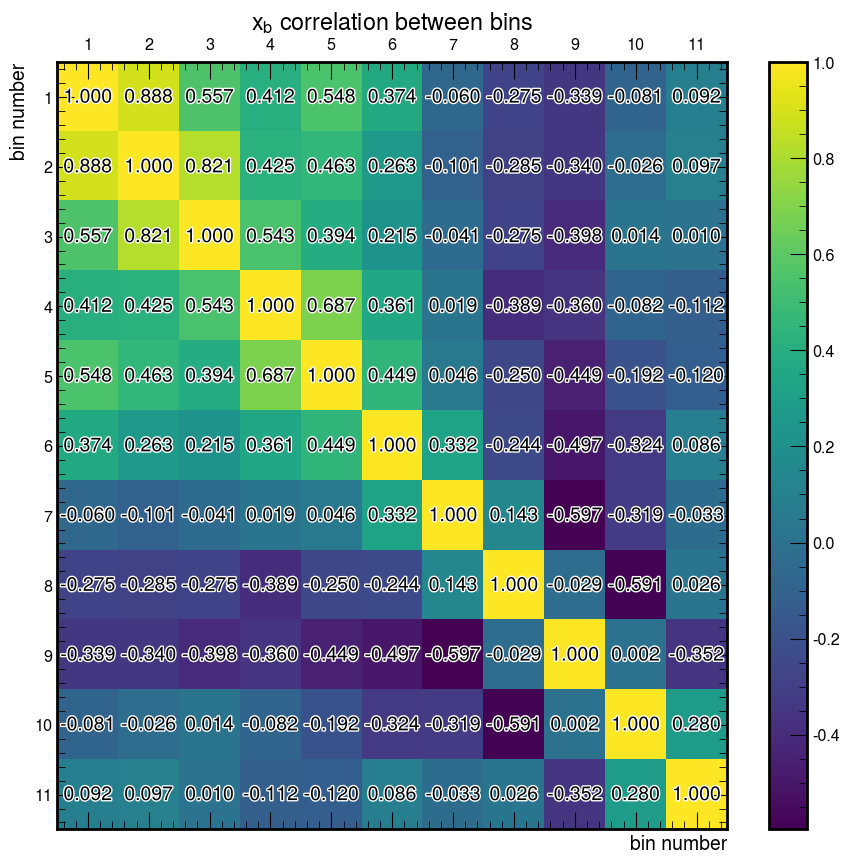

In [101]:
corr_matrix = weighted_corr(hist_list, weights = [1]*len(hist_list))

np.set_printoptions(precision=3, suppress=True)
print(corr_matrix)

plot_matrix(corr_matrix, title = r'x$_b$ correlation between bins', savefig = './plots/xb_11bin_1M_50iter_corr_matrix.pdf')


In [102]:
np.set_printoptions(precision=3, suppress = False)

print(hist_list.shape)
print(hist_list[::5])

mean_hist = np.mean(hist_list, axis = 0)
std_hist = np.std(hist_list, axis = 0)

print(mean_hist)
print(std_hist)

# calc other histograms to compare to
target_hist, _  = np.histogram(X0_tot[:,0,0], bins=bins, density=True)
nominal_hist, _ = np.histogram(X1_tot[:,0,0], bins=bins, density=True)

# add last value to hist for plotting reasonscenter_mass_energy = '(13 TeV)'
target_hist  = np.concatenate((target_hist, [target_hist[-1]]))
nominal_hist = np.concatenate((nominal_hist, [nominal_hist[-1]]))

mean_hist    = np.concatenate((mean_hist, [mean_hist[-1]]))
std_hist     = np.concatenate((std_hist, [std_hist[-1]]))



(50, 11)
[[0.012 0.147 0.235 0.341 0.489 0.757 1.297 2.324 2.847 1.526 0.025]
 [0.012 0.151 0.24  0.347 0.497 0.754 1.296 2.31  2.817 1.549 0.027]
 [0.012 0.149 0.235 0.342 0.493 0.752 1.288 2.314 2.832 1.557 0.026]
 [0.013 0.153 0.244 0.35  0.502 0.762 1.302 2.32  2.816 1.517 0.023]
 [0.012 0.15  0.241 0.346 0.496 0.75  1.282 2.328 2.83  1.541 0.024]
 [0.012 0.148 0.238 0.34  0.485 0.752 1.299 2.338 2.823 1.539 0.025]
 [0.012 0.15  0.239 0.345 0.496 0.754 1.281 2.313 2.842 1.543 0.024]
 [0.012 0.149 0.239 0.342 0.492 0.739 1.298 2.348 2.827 1.53  0.025]
 [0.012 0.149 0.239 0.345 0.5   0.742 1.292 2.31  2.838 1.549 0.022]
 [0.012 0.149 0.237 0.341 0.495 0.753 1.293 2.316 2.825 1.552 0.025]]
[0.012 0.15  0.238 0.344 0.495 0.753 1.291 2.318 2.834 1.542 0.024]
[0.    0.002 0.002 0.003 0.004 0.006 0.008 0.011 0.013 0.012 0.001]


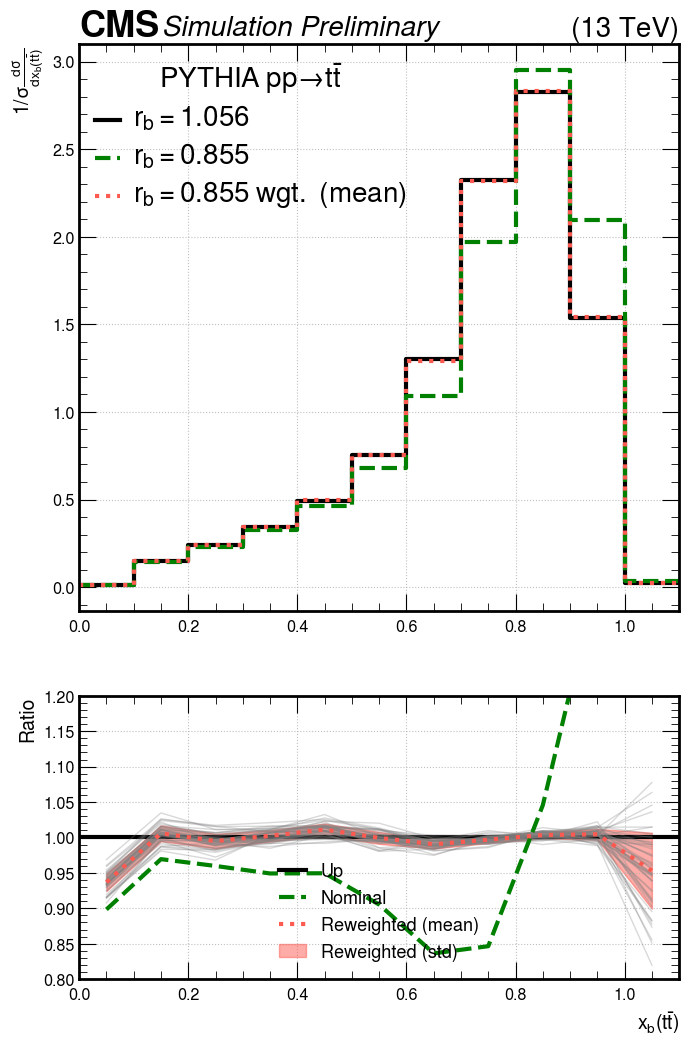

In [103]:
# plot the hists above
ratio_ylim = [0.80, 1.20]

# Create figure with two subplots
fig, axes = plt.subplots(nrows=2, figsize=(8,11), gridspec_kw={'height_ratios': [2, 1]})
fig.tight_layout(pad=1)

# First subplot
bin_centers = (bins[:-1] + bins[1:]) / 2.0

axes[0].step(bins, target_hist, label = r'$r_{b}=1.056$', where='post', **plt_style_11a)
axes[0].step(bins, nominal_hist, label = r'$r_{b}=0.855$', where='post', **plt_style_10a)
axes[0].step(bins, mean_hist, label = r'$r_{b}=0.855 \; wgt.$ (mean)', where='post', **plt_style_12a)

# Calculate the ratios of histograms
ratio_0 = target_hist / target_hist
ratio_1 = mean_hist / target_hist
ratio_std = std_hist / mean_hist
ratio_2 = nominal_hist / target_hist

make_legend(axes[0], pythia_text)
obs = r'x_{b}'
part = r't\bar{t}'
unit = ''
inv_unit = ''
start = bins[0]
stop = bins[-1]


# Constructing the label using Python string formatting
label = r'$1$/$\sigma \frac{d\sigma}{d %s(%s)}$ %s' % (obs, part, inv_unit)

axes[0].set_ylabel(label)
# axes[0].set_yscale('log')
axes[0].grid(True)

# Second subplot

axes[1].plot([start, stop], [1,1], '-', color='black',  linewidth=3, label='Up')
for hist in hist_list:
    axes[1].plot(bin_centers, hist/target_hist[:-1], linewidth=1, alpha = 0.3, color = 'grey')
axes[1].plot(bin_centers, ratio_2[:-1], label='Nominal', **plt_style_10a)
axes[1].plot(bin_centers, ratio_1[:-1], label = 'Reweighted (mean)', **plt_style_12a)
axes[1].fill_between(bin_centers, (ratio_1*(1+ratio_std))[:-1], (ratio_1*(1-ratio_std))[:-1], color='#FC5A50', alpha = 0.5, label = 'Reweighted (std)') 

# axes[1].plot(bin_centers, ratio_3[:-1], label='rwgt valentina', **plt_style_13a)

axes[1].set_xlabel(fr'${obs}({part}){unit}$')
axes[1].set_ylabel(f'Ratio')
axes[1].grid(True)

# print(f'uncertainty NLO: {uncert_nrm_list[0]}')

plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.1, top=0.95)
axes[1].set_ylim(ratio_ylim)

axes[0].set_xlim([start,stop])
axes[1].set_xlim([start,stop])
axes[1].legend(fontsize=13)

#hep.cms.label(ax=axes[0], data=False, paper=False, lumi=None, fontsize=20, loc=0)
hep.cms.text(hep_text, loc=0, fontsize=20, ax=axes[0])
axes[0].text(1.0, 1.05, '(13 TeV)', ha="right", va="top", fontsize=20, transform=axes[0].transAxes)

plt.savefig('./plots/xb_11bin_1M_50iter_bootstrap_hist.pdf')

plt.show()


# save hists to disk for faster plotting without recalculating

n_list = [target_hist, mean_hist, nominal_hist]

hist_comp = n_list, ratio_std, bins
hist_comp = np.array(hist_comp, dtype=object)

np.save('./plots/xb_11bin_1M_50iter_corr_matrix.npy', hist_comp)



In [104]:
# original: 49 bin Xb
bins = np.linspace(0,1.1,50)
'''

hist_list = []

for i, wgt in enumerate(wgts_list):
    hist, _ = np.histogram(X1_tot[:,0,0], weights = wgt, bins = bins, density=True)
    hist_list.append(hist)
    print(f'calculated hist for {i + 1} iterations')

hist_list = np.array(hist_list)
np.save(f'{data_dir}/xb_49bin_hist_1M_50iter.npy', hist_list)
'''
hist_list = np.load(f'{data_dir}/xb_49bin_hist_1M_50iter.npy')
print(hist_list.shape)


(50, 49)


/tmp/ipykernel_259/2852832631.py:34: RuntimeWarning: invalid value encountered in true_divide
  weighted_correlation = cov / std_dev_matrix


[[ 1.       nan  0.716 ...  0.095  0.05  -0.009]
 [   nan    nan    nan ...    nan    nan    nan]
 [ 0.716    nan  1.    ...  0.078 -0.007 -0.025]
 ...
 [ 0.095    nan  0.078 ...  1.     0.958  0.907]
 [ 0.05     nan -0.007 ...  0.958  1.     0.976]
 [-0.009    nan -0.025 ...  0.907  0.976  1.   ]]


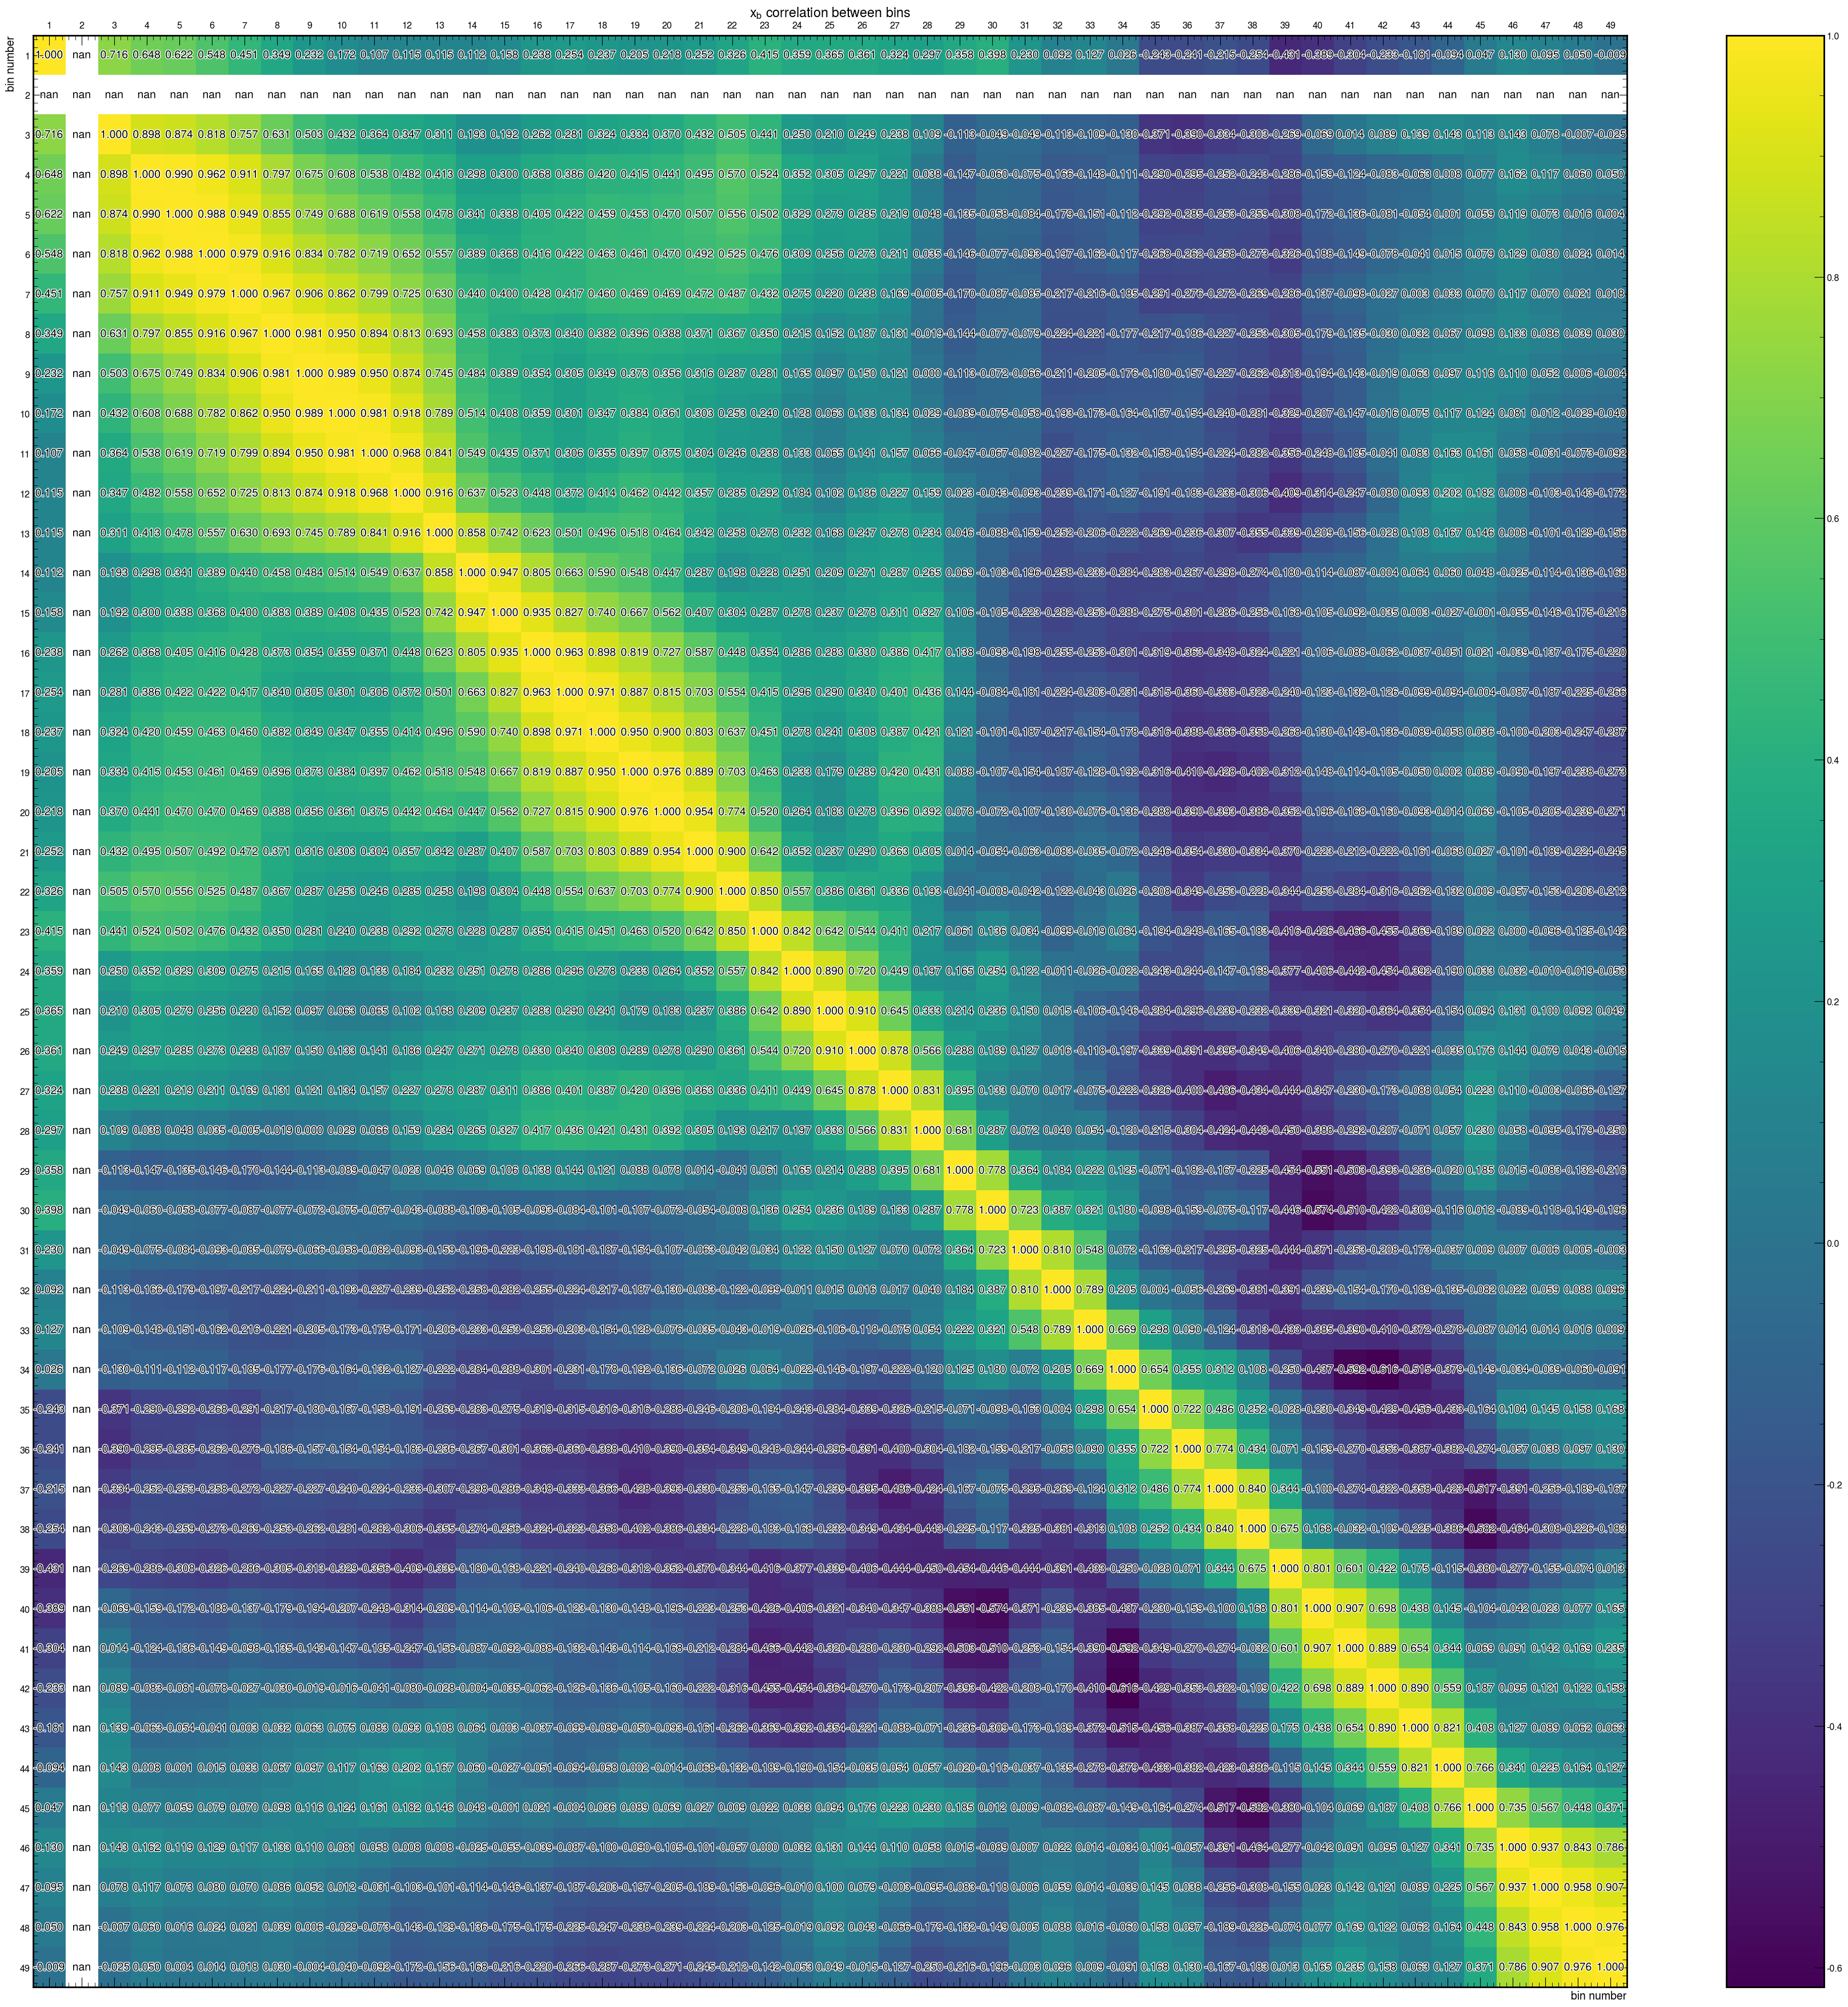

In [105]:
corr_matrix = weighted_corr(hist_list, weights = [1]*len(hist_list))

np.set_printoptions(precision=3, suppress=True)
print(corr_matrix)

plot_matrix(corr_matrix, title = r'x$_b$ correlation between bins', savefig = './plots/xb_49bin_1M_50iter_corr_matrix.pdf')


In [106]:
np.set_printoptions(precision=3, suppress = False)

print(hist_list.shape)
print(hist_list[::5])

mean_hist = np.mean(hist_list, axis = 0)
std_hist = np.std(hist_list, axis = 0)

print(mean_hist)
print(std_hist)

# calc other histograms to compare to
target_hist, _  = np.histogram(X0_tot[:,0,0], bins=bins, density=True)
nominal_hist, _ = np.histogram(X1_tot[:,0,0], bins=bins, density=True)

# add last value to hist for plotting reasonscenter_mass_energy = '(13 TeV)'
target_hist  = np.concatenate((target_hist, [target_hist[-1]]))
nominal_hist = np.concatenate((nominal_hist, [nominal_hist[-1]]))

mean_hist    = np.concatenate((mean_hist, [mean_hist[-1]]))
std_hist     = np.concatenate((std_hist, [std_hist[-1]]))



(50, 49)
[[5.465e-05 0.000e+00 2.054e-04 2.143e-02 8.591e-02 1.155e-01 1.493e-01
  1.641e-01 1.878e-01 2.066e-01 2.246e-01 2.423e-01 2.562e-01 2.714e-01
  3.160e-01 3.391e-01 3.719e-01 3.937e-01 4.308e-01 4.659e-01 4.998e-01
  5.494e-01 6.054e-01 6.794e-01 7.525e-01 8.332e-01 9.276e-01 1.047e+00
  1.185e+00 1.380e+00 1.594e+00 1.831e+00 2.104e+00 2.352e+00 2.595e+00
  2.831e+00 2.960e+00 2.969e+00 2.856e+00 2.612e+00 2.328e+00 1.918e+00
  1.508e+00 1.010e+00 3.120e-01 2.867e-02 1.350e-02 1.193e-02 8.107e-03]
 [5.631e-05 0.000e+00 2.129e-04 2.198e-02 8.827e-02 1.187e-01 1.532e-01
  1.684e-01 1.928e-01 2.122e-01 2.306e-01 2.489e-01 2.611e-01 2.736e-01
  3.199e-01 3.460e-01 3.799e-01 4.017e-01 4.390e-01 4.741e-01 5.078e-01
  5.563e-01 6.048e-01 6.639e-01 7.445e-01 8.351e-01 9.430e-01 1.067e+00
  1.187e+00 1.366e+00 1.581e+00 1.813e+00 2.081e+00 2.331e+00 2.599e+00
  2.810e+00 2.918e+00 2.926e+00 2.826e+00 2.607e+00 2.340e+00 1.942e+00
  1.537e+00 1.032e+00 3.285e-01 3.189e-02 1.454e-02 1.

/tmp/ipykernel_259/1371785193.py:16: RuntimeWarning: invalid value encountered in true_divide
  ratio_0 = target_hist / target_hist
/tmp/ipykernel_259/1371785193.py:17: RuntimeWarning: divide by zero encountered in true_divide
  ratio_1 = mean_hist / target_hist
/tmp/ipykernel_259/1371785193.py:17: RuntimeWarning: invalid value encountered in true_divide
  ratio_1 = mean_hist / target_hist
/tmp/ipykernel_259/1371785193.py:18: RuntimeWarning: invalid value encountered in true_divide
  ratio_std = std_hist / mean_hist
/tmp/ipykernel_259/1371785193.py:19: RuntimeWarning: divide by zero encountered in true_divide
  ratio_2 = nominal_hist / target_hist
/tmp/ipykernel_259/1371785193.py:19: RuntimeWarning: invalid value encountered in true_divide
  ratio_2 = nominal_hist / target_hist
/tmp/ipykernel_259/1371785193.py:41: RuntimeWarning: divide by zero encountered in true_divide
  axes[1].plot(bin_centers, hist/target_hist[:-1], linewidth=1, alpha = 0.3, color = 'grey')
/tmp/ipykernel_259/1371

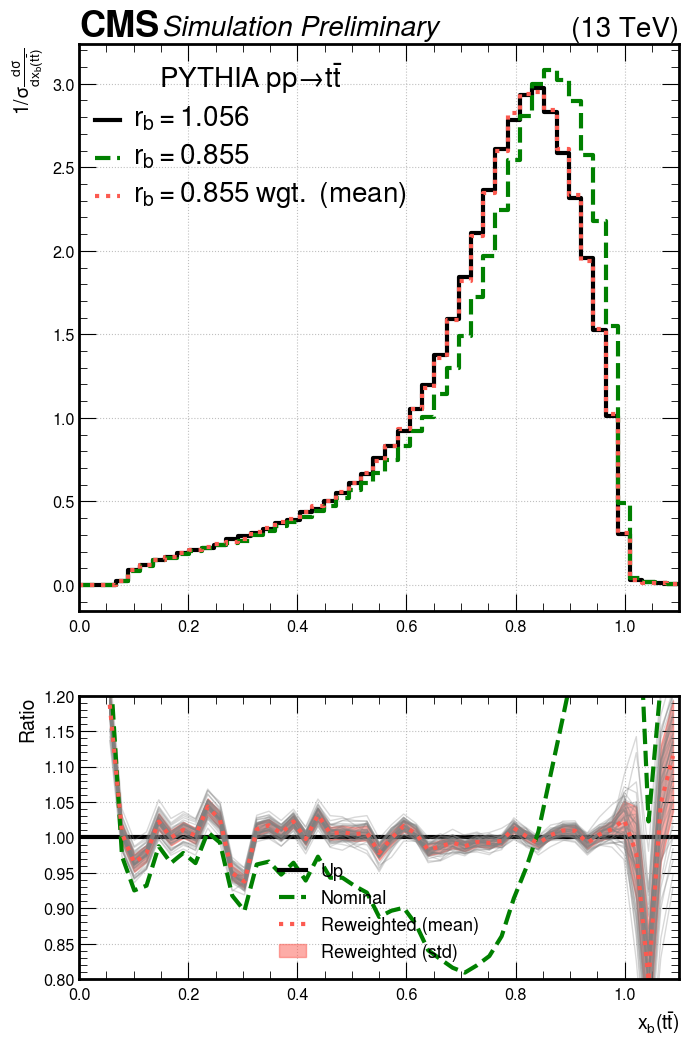

In [107]:
# plot the hists above
ratio_ylim = [0.80, 1.20]

# Create figure with two subplots
fig, axes = plt.subplots(nrows=2, figsize=(8,11), gridspec_kw={'height_ratios': [2, 1]})
fig.tight_layout(pad=1)

# First subplot
bin_centers = (bins[:-1] + bins[1:]) / 2.0

axes[0].step(bins, target_hist, label = r'$r_{b}=1.056$', where='post', **plt_style_11a)
axes[0].step(bins, nominal_hist, label = r'$r_{b}=0.855$', where='post', **plt_style_10a)
axes[0].step(bins, mean_hist, label = r'$r_{b}=0.855 \; wgt.$ (mean)', where='post', **plt_style_12a)

# Calculate the ratios of histograms
ratio_0 = target_hist / target_hist
ratio_1 = mean_hist / target_hist
ratio_std = std_hist / mean_hist
ratio_2 = nominal_hist / target_hist

make_legend(axes[0], pythia_text)
obs = r'x_{b}'
part = r't\bar{t}'
unit = ''
inv_unit = ''
start = bins[0]
stop = bins[-1]


# Constructing the label using Python string formatting
label = r'$1$/$\sigma \frac{d\sigma}{d %s(%s)}$ %s' % (obs, part, inv_unit)

axes[0].set_ylabel(label)
# axes[0].set_yscale('log')
axes[0].grid(True)

# Second subplot

axes[1].plot([start, stop], [1,1], '-', color='black',  linewidth=3, label='Up')
for hist in hist_list:
    axes[1].plot(bin_centers, hist/target_hist[:-1], linewidth=1, alpha = 0.3, color = 'grey')
axes[1].plot(bin_centers, ratio_2[:-1], label='Nominal', **plt_style_10a)
axes[1].plot(bin_centers, ratio_1[:-1], label = 'Reweighted (mean)', **plt_style_12a)
axes[1].fill_between(bin_centers, (ratio_1*(1+ratio_std))[:-1], (ratio_1*(1-ratio_std))[:-1], color='#FC5A50', alpha = 0.5, label = 'Reweighted (std)') 

# axes[1].plot(bin_centers, ratio_3[:-1], label='rwgt valentina', **plt_style_13a)

axes[1].set_xlabel(fr'${obs}({part}){unit}$')
axes[1].set_ylabel(f'Ratio')
axes[1].grid(True)

# print(f'uncertainty NLO: {uncert_nrm_list[0]}')

plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.1, top=0.95)
axes[1].set_ylim(ratio_ylim)

axes[0].set_xlim([start,stop])
axes[1].set_xlim([start,stop])
axes[1].legend(fontsize=13)

#hep.cms.label(ax=axes[0], data=False, paper=False, lumi=None, fontsize=20, loc=0)
hep.cms.text(hep_text, loc=0, fontsize=20, ax=axes[0])
axes[0].text(1.0, 1.05, '(13 TeV)', ha="right", va="top", fontsize=20, transform=axes[0].transAxes)

plt.savefig('./plots/xb_49bin_1M_50iter_bootstrap_hist.pdf')

plt.show()


# save hists to disk for faster plotting without recalculating

n_list = [target_hist, mean_hist, nominal_hist]

hist_comp = n_list, ratio_std, bins
hist_comp = np.array(hist_comp, dtype=object)

np.save('./plots/xb_49bin_1M_50iter_corr_matrix.npy', hist_comp)

